In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# --------------------------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [19]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, meta=meta, 
                                    traceid=traceid,
                                    response_type=response_type, 
                                    trial_epoch=trial_epoch,
                                    responsive_test=responsive_test,
                                    responsive_thr=responsive_thr)
cells0 = aggr.get_all_responsive_cells(cells0, NDATA0)
# input data
NDATA = aggr.get_neuraldata_for_included_cells(cells0, NDATA0)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled


# Load decoding results

In [21]:
C_value=1.0
test_split=0.2
cv_nfolds=5
chance_level = 1/8. if experiment=='gratings' else 0.5

In [83]:
analysis_type='by_fov'
test_type= 'size_single' #'size_single' #'size_single'
class_name = 'morphlevel'
variation_name = 'size' if test_type is not None else None
match_rfs = False
overlap_thr= None #[0, 0.25, 0.5]

if test_type is None:
    test_str = 'default'
else:
    test_str = '%s_%s' % (test_type, variation_name) \
                    if (variation_name is not None and class_name!='morphlevel') \
    else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)
print(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single


## Output dirs

In [23]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'decoding', 'blobs')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00
dff-ROC__stimulus__noRF__C1.00


In [92]:
FIGDIR

'/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/decoding/blobs'

In [24]:
# rename_dirs = glob.glob(os.path.join(rootdir, 'JC*', '2019*', 'FOV*', 'combined_blobs*', 
#                       'traces/traces001*', 'decoding/morphlevel', 'size_single_size' ))

## Load

In [25]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
print(class_name, variation_name)
iterdf, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, # break_correlations=True, 
                          variation_name=variation_name,
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]
    

morphlevel size
(V1) Found 15 paths
(Lm) Found 16 paths
(Li) Found 17 paths
    checking for break-corrs
(V1) Found 15 paths
(Lm) Found 16 paths
(Li) Found 17 paths


In [26]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [27]:
print(analysis_type, test_type)
grouper = ['visual_area', 'condition', 'datakey', 'intact'] #, 'novel']

mean_df = dec.average_across_iterations_by_fov(iterdf,
                        analysis_type=analysis_type, test_type=test_type,
                        grouper=grouper)
if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("intact/break_cc:", mean_df['intact'].unique())

by_fov size_single
novel: [False  True]
conditions: ['data' 'shuffled']
intact/break_cc: [False  True]


## Drop repeats

In [28]:
match_ncells=False
# ---------------------------------
all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() if match_ncells\
                else all_counts.groupby('visual_area')['n_cells'].max().max() 
min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() if match_ncells\
                else 10
print(min_ncells, max_ncells)
# Get sample sizes
n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
xlabels = [1, 32, 96, max_ncells]
# filter too few/too many cells
fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
passdf = mean_df[(mean_df['n_cells']>=min_ncells) 
                    & (mean_df['n_cells']<=max_ncells)].copy()
counts = passdf[['visual_area', 'datakey', 'n_cells']].copy().drop_duplicates()
# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')
finaldf = pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])
# Add some extralabels
passdf['noise_corrs'] = ['intact' if f else 'shuffled' for f in passdf['intact'].values]
finaldf['noise_corrs'] = ['intact' if f else 'shuffled' for f in finaldf['intact'].values]

finaldf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

10 196.0
[V1] Animalid does not exist: JC078 


V1    9
Lm    9
Li    8
Name: visual_area, dtype: int64

In [29]:
#NDATA
ndata_final = pd.concat([g for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])

#### Overall test accuracy by stimulus config (if test_type=='size_single')

<IPython.core.display.Javascript object>


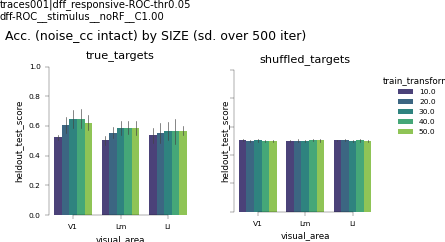

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 scores_avg_fov__dff-ROC__stimulus__noRF__C1.00


In [30]:
if (test_type is not None) and (analysis_type=='by_fov'):
    # Look at noise-corrrs INTACT:
    hue_name = 'train_transform' #if test_type is not None else 'intact'
    metric = 'heldout_test_score'
    column_name = 'condition'
    # -------------------------------------------------------------------
    plotd0 = finaldf[(finaldf['intact'])].copy()
    plotd = plotd0.groupby(['visual_area', 'datakey', column_name, hue_name])\
                    .mean().reset_index()
    hue_values = sorted(plotd[hue_name].unique())
    col_list = sns.color_palette('viridis', n_colors=len(hue_values))
    cond_colors = dict((k, v) for k, v in zip(hue_values, col_list))
    %matplotlib notebook
    fig, axn = pl.subplots(1, 2, figsize=(5.5,3), sharex=True, sharey=True)
    for ai, (cond, df_) in enumerate(plotd.groupby(column_name)):
        title = 'true_targets' if cond=='data' else 'shuffled_targets'
        ai = 0 if cond=='data' else 1
        ax=axn[ai]; ax.set_title(title)
        sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                   hue=hue_name, palette=cond_colors, ci='sd',
                   order=visual_areas, errwidth=0.5)
        ax.legend_.remove()
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, title=hue_name)
    ax.set_box_aspect(1)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
    ax.set_ylim([0, 1])
    fig.text(0.01, 0.85, \
             'Acc. (noise_cc intact) by SIZE (sd. over %i iter)' % n_iters)
    sns.despine(trim=True)
    pl.subplots_adjust(left=0.1, right=0.76, bottom=0.2, top=0.75, wspace=0.3)
    figname = 'scores_avg_fov__%s' % aggr_id
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

#### Compare intact-v-shuffled noise corrs & novel-v-trained config

<IPython.core.display.Javascript object>


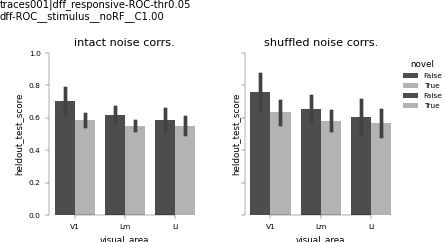

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 avg_scores_intact-v-shuff-noisecorrs_novel-v-trained__dff-ROC__stimulus__noRF__C1.00


In [31]:
if (test_type is not None) and (analysis_type=='by_fov'):
    hue_name = 'novel' #if test_type is not None else 'intact'
    metric = 'heldout_test_score'
    column_name = 'noise_corrs'
    # ---------------------------------------------
    plotd0 = finaldf[finaldf.condition=='data'].copy() #[(finaldf['intact'])].copy()
    plotd = plotd0.groupby(['visual_area', 'datakey', hue_name, column_name])\
                    .mean().reset_index()
    hue_values = sorted(plotd[hue_name].unique())
    cond_colors = {hue_values[0]: [0.3]*3, hue_values[1]: [0.7]*3}    
    %matplotlib notebook
    fig, axn = pl.subplots(1, 2, figsize=(5.5,3), sharex=True, sharey=True)
    for ai, (cond, df_) in enumerate(plotd.groupby(column_name)):
        title = '%s noise corrs.' % cond
        ai = 0 if cond=='intact' else 1
        ax=axn[ai]; ax.set_title(title)
        sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                   hue=hue_name, palette=cond_colors, ci='sd',
                   order=visual_areas)
        sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                   hue=hue_name, palette=cond_colors, ci='sd',
                   order=visual_areas)
        ax.legend_.remove()
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
             title=hue_name)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
    ax.set_ylim([0, 1])

    sns.despine(trim=True)
    pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.3)
    figname = 'avg_scores_intact-v-shuff-noisecorrs_novel-v-trained__%s' % aggr_id
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

#### Paired accuracy, compare intact v. shuffled noise-corrs

In [32]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA0['datakey'].unique(), 
                            experiment=experiment,
                            images_only=True, rename=True,
                            return_incorrect=True, return_all=False)
incorrect_stim.keys()

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])

In [35]:
finaldf['novel'].unique()

array([False,  True])

In [37]:
maindf = finaldf.copy() #[finaldf.train_transform!=10].copy()

if test_type is not None:
    paired_df = maindf[~(maindf.novel)]\
            .groupby(['visual_area', 'datakey', 'noise_corrs', 'condition']).mean()\
            .reset_index()
else:
    paired_df = maindf\
            .groupby(['visual_area', 'datakey', 'noise_corrs', 'condition']).mean()\
            .reset_index()

In [38]:
dkey_counts = paired_df[['visual_area', 'datakey']].drop_duplicates()\
                .groupby('visual_area').count()

<IPython.core.display.Javascript object>


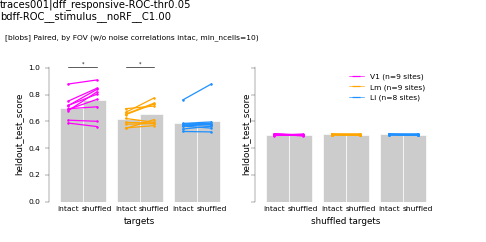

   t_stat  p_val visual_area
1  -2.435  0.041          Lm
   t_stat  p_val visual_area
0  -3.001  0.017          V1
   t_stat  p_val visual_area condition
0   -3.00   0.02          V1      data
1   -2.44   0.04          Lm      data
2   -1.21   0.26          Li      data
0    0.97   0.36          V1  shuffled
1    1.21   0.26          Lm  shuffled
2    1.46   0.19          Li  shuffled
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 paired_accuracy_break_noisecorrs_heldout_test_score


In [84]:
%matplotlib notebook

metric='heldout_test_score'
if analysis_type=='by_fov':
    s_=[]
    corr_colors={'intact': 'darkblue', 'shuffled': 'lightblue'}
    fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
    for ai, (cond, datad) in enumerate(paired_df.groupby('condition')):
        ax=axn[ai]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1='intact', c2='shuffled', compare_var='noise_corrs',
                         return_stats=True, marker='.', size=2, edgecolor=['w']*3,
                         facecolor=[0.8]*3, annotate=True, sig_lw=0.5,
                         sig_fontsize=4, sig_height=0.005, sig_offset=None)
        pstats['condition'] = cond
        s_.append(pstats)
statsdf = pd.concat(s_, axis=0)
print(statsdf.round(2).to_string())

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn):
    ax.set_xlabel('')
    #xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    #ax.set_xticklabels(xtick_labels)
    ax.set_ylim([0, 1.01])
labels = ['%s (n=%i sites)' % (va, dkey_counts.loc[va]) for va in visual_areas]
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=labels, markers='_')
axn[1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)

fig.text(0.01, 0.85, \
    '[%s] Paired, by FOV (w/o noise correlations intac, min_ncells=%i)'\
         % (experiment, min_ncells))
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))

figname = 'paired_accuracy_break_noisecorrs_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(dst_dir, figname)

# Final plots

## noise corrs for selected data

In [40]:
import analyze2p.correlations as cr

In [41]:
experiment

'blobs'

In [43]:
select_stimuli='all'
min_ncells=10
distance_var='cortical_distance'
if 'experiment' not in ndata_final.columns:
    ndata_final['experiment'] = experiment
DISTS = cr.aggregate_ccdist(ndata_final, experiment=experiment, rfdf=None, rfpolys=None,
                    SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                    distance_var=distance_var, verbose=True)

Dist: cortical_distance
Li 20190315_JC070_fov1 blobs
Li 20190322_JC073_fov1 blobs
Li 20190422_JC076_fov1 blobs
Li 20190602_JC091_fov1 blobs
Li 20190612_JC099_fov1 blobs
Li 20190614_JC091_fov1 blobs
Li 20191018_JC113_fov1 blobs
Li 20191111_JC120_fov1 blobs
Lm 20190322_JC073_fov1 blobs
Lm 20190422_JC076_fov1 blobs
Lm 20190430_JC078_fov1 blobs
Lm 20190504_JC078_fov1 blobs
Lm 20190506_JC080_fov1 blobs
Lm 20190508_JC083_fov1 blobs
Lm 20190525_JC084_fov1 blobs
Lm 20190618_JC097_fov1 blobs
Lm 20190627_JC091_fov1 blobs
V1 20190501_JC076_fov1 blobs
V1 20190507_JC083_fov1 blobs
V1 20190512_JC083_fov1 blobs
V1 20190522_JC084_fov1 blobs
V1 20190613_JC097_fov1 blobs
V1 20190616_JC097_fov1 blobs
V1 20190617_JC097_fov1 blobs
V1 20190622_JC085_fov1 blobs
V1 20191006_JC110_fov1 blobs
3 datasets w wrong configs:
    ('Li', '20190315_JC070_fov1')
    ('Li', '20190322_JC073_fov1')
    ('Lm', '20190322_JC073_fov1')
0 datasets w/out RF fits:


In [44]:
meancc = DISTS.groupby(['visual_area', 'datakey']).median().reset_index()
meancc.head()

,visual_area,datakey,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,n_cells
0,Li,20190422_JC076_fov1,253.0,294.0,0.067459,0.101359,278.749904,29.0
1,Li,20190602_JC091_fov1,53.0,249.0,0.309763,0.199220,247.526280,87.0
2,Li,20190612_JC099_fov1,109.0,213.0,0.121431,0.094503,283.882429,48.0
3,Li,20190614_JC091_fov1,60.0,282.0,0.083079,0.057968,292.241832,78.0
4,Li,20191018_JC113_fov1,87.0,124.0,0.124284,0.154700,234.572844,47.0


In [45]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


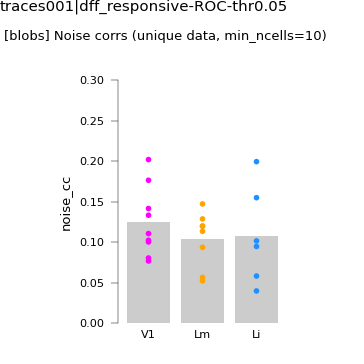

    A   B  Paired  Parametric  U-val       Tail  p-corr p-adjust  eta-square
0  Li  Lm   False       False   24.0  two-sided     1.0   fdr_by    0.002019
1  Li  V1   False       False   20.0  two-sided     1.0   fdr_by    0.027386
2  Lm  V1   False       False   29.0  two-sided     1.0   fdr_by    0.067769
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 noise_corrs_blobs


In [85]:
%matplotlib notebook
fig, stats_ = pplot.plot_standard_panel(meancc, 'noise_cc', posthoc='fdr_by',
                                        return_stats=True)
fig.axes[0].set_ylim([0, 0.3])
ignore_cols=['Contrast', 'p-unc', 'metric']
print_cols=[p for p in stats_.columns if p not in ignore_cols]
print(stats_[print_cols].to_string())
fig.text(0.01, 0.9, '[%s] Noise corrs (unique data, min_ncells=%i)' \
         % (experiment, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'noise_corrs_%s' % experiment
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)

In [47]:
paired_df['novel'].unique()

array([False])

## Calculate scores over chance

In [57]:
paired_df.head()

,visual_area,datakey,noise_corrs,condition,intact,novel,train_transform,test_transform,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,n_trials,iteration,n_cells
0,Li,20190315_JC070_fov1,intact,data,True,False,30.0,30.0,0.001267,0.000419,0.538892,0.907421,0.542333,1.0,5061.3364,60.0,249.5,22.0
1,Li,20190315_JC070_fov1,intact,shuffled,True,False,30.0,30.0,0.001331,0.000422,0.499132,0.890567,0.497667,1.0,5061.3364,60.0,249.5,22.0
2,Li,20190315_JC070_fov1,shuffled,data,False,False,30.0,30.0,0.001052,0.000334,0.564051,0.932549,0.563767,1.0,4933.8764,60.0,249.5,22.0
3,Li,20190315_JC070_fov1,shuffled,shuffled,False,False,30.0,30.0,0.001043,0.000333,0.498257,0.912168,0.503733,1.0,4933.8764,60.0,249.5,22.0
4,Li,20190322_JC073_fov1,intact,data,True,False,30.0,30.0,0.000975,0.000338,0.555952,0.999158,0.564267,1.0,5044.4456,60.0,249.5,38.0


In [49]:
metric='heldout_test_score'
compare_var = 'noise_corrs'
# c1, c2 = sorted(vg[compare_var].unique())
c1 = 'shuffled'
c2 = 'intact'
scores_over_chance = dec.calculate_relative_scores(paired_df, compare_var=compare_var,
                                                  c1=c1, c2=c2, metric=metric)

In [74]:
df_ = scores_over_chance.copy() #
#df_ = scores_over_chance[~scores_over_chance.datakey.isin(incorrect_stim)]

In [75]:
df_.head()

,visual_area,datakey,intact_rel,shuffled_rel,shuffled_v_intact,chance,n_cells
0,Li,20190315_JC070_fov1,1.089752,1.119177,0.042807,0.5007,22
1,Li,20190322_JC073_fov1,1.131778,1.105956,-0.030620,0.4975,38
2,Li,20190422_JC076_fov1,1.163501,1.192652,0.022246,0.500467,29
3,Li,20190602_JC091_fov1,1.520336,1.779771,0.240848,0.497133,87
4,Li,20190612_JC099_fov1,1.125455,1.137537,0.015074,0.504167,48


In [76]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


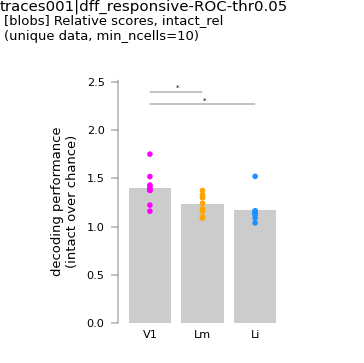

    A   B  Paired  Parametric  U-val       Tail    p-corr p-adjust  eta-square
0  Li  Lm   False       False   22.0  two-sided  0.355540   fdr_by    0.054107
1  Li  V1   False       False    9.0  two-sided  0.029627   fdr_by    0.350837
2  Lm  V1   False       False   11.0  two-sided  0.029627   fdr_by    0.277949
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 rel_scores_intact_rel-corrs_blobs


In [86]:
%matplotlib notebook
posthoc = 'fdr_by'
metric = 'intact_rel'
# ---------------------
fig, stats_ = pplot.plot_standard_panel(df_, metric, posthoc=posthoc, return_stats=True)
fig.axes[0].set_ylabel('decoding performance\n(intact over chance)')
ignore_cols=['Contrast', 'p-unc', 'metric']
print_cols=[p for p in stats_.columns if p not in ignore_cols]
print(stats_[print_cols].to_string())
#fig.axes[0].set_ylim([0, 3])
fig.text(0.01, 0.9, '[%s] Relative scores, %s\n(unique data, min_ncells=%i)' \
         % (experiment, metric, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'rel_scores_%s-corrs_%s' % (metric, experiment)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


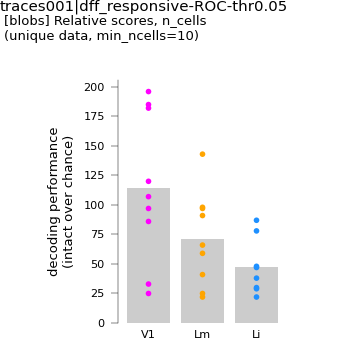

    A   B  Paired  Parametric  U-val       Tail    p-corr p-adjust  eta-square
0  Li  Lm   False       False   22.5  two-sided  0.386250   fdr_by    0.115686
1  Li  V1   False       False   13.0  two-sided  0.167106   fdr_by    0.320355
2  Lm  V1   False       False   23.0  two-sided  0.365529   fdr_by    0.143504
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 rel_scores_n_cells-corrs_blobs


In [87]:
%matplotlib notebook
posthoc = 'fdr_by'
metric = 'n_cells'
# ---------------------
fig, stats_ = pplot.plot_standard_panel(df_, metric, posthoc=posthoc, return_stats=True)
fig.axes[0].set_ylabel('decoding performance\n(intact over chance)')
ignore_cols=['Contrast', 'p-unc', 'metric']
print_cols=[p for p in stats_.columns if p not in ignore_cols]
print(stats_[print_cols].to_string())
#fig.axes[0].set_ylim([0, 2])
fig.text(0.01, 0.9, '[%s] Relative scores, %s\n(unique data, min_ncells=%i)' \
         % (experiment, metric, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'rel_scores_%s-corrs_%s' % (metric, experiment)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


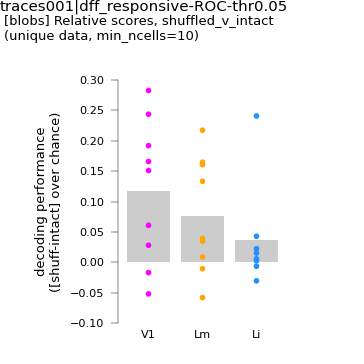

    A   B  Paired  Parametric  U-val       Tail    p-corr p-adjust  eta-square
0  Li  Lm   False       False   27.0  two-sided  0.782424   fdr_by    0.047190
1  Li  V1   False       False   21.0  two-sided  0.782424   fdr_by    0.131636
2  Lm  V1   False       False   31.0  two-sided  0.782424   fdr_by    0.034946
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 rel_scores_shuffled_v_intact-corrs_blobs


In [88]:
%matplotlib notebook
posthoc = 'fdr_by'
metric = 'shuffled_v_intact'
# ---------------------
fig, stats_ = pplot.plot_standard_panel(df_, metric, posthoc=posthoc,
                                       return_stats=True)
fig.axes[0].set_ylabel('decoding performance\n([shuff-intact] over chance)')
ignore_cols=['Contrast', 'p-unc', 'metric']
print_cols=[p for p in stats_.columns if p not in ignore_cols]
print(stats_[print_cols].to_string())

fig.axes[0].set_ylim([-0.1, 0.3])
fig.text(0.01, 0.9, '[%s] Relative scores, %s\n(unique data, min_ncells=%i)' \
         % (experiment, metric, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'rel_scores_%s-corrs_%s' % (metric, experiment)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)

In [81]:
df_

,visual_area,datakey,intact_rel,shuffled_rel,shuffled_v_intact,chance,n_cells
0,Li,20190315_JC070_fov1,1.089752,1.119177,0.042807,0.5007,22
1,Li,20190322_JC073_fov1,1.131778,1.105956,-0.030620,0.4975,38
2,Li,20190422_JC076_fov1,1.163501,1.192652,0.022246,0.500467,29
3,Li,20190602_JC091_fov1,1.520336,1.779771,0.240848,0.497133,87
4,Li,20190612_JC099_fov1,1.125455,1.137537,0.015074,0.504167,48
5,Li,20190614_JC091_fov1,1.159104,1.174065,0.002338,0.499067,78
6,Li,20191018_JC113_fov1,1.136941,1.149471,0.005736,0.503322,47
7,Li,20191111_JC120_fov1,1.038324,1.041419,-0.006639,0.502117,30
8,Lm,20190322_JC073_fov1,1.099541,1.137715,0.034743,0.499867,25
9,Lm,20190422_JC076_fov1,1.157505,1.163671,0.008796,0.500233,22


#### Split by CONFIG:  compare intact vs. shuffled noise-corrs, if test_type is not None

In [66]:
maindf.columns

Index(['visual_area', 'condition', 'datakey', 'intact', 'novel',
       'train_transform', 'test_transform', 'fit_time', 'score_time',
       'test_score', 'train_score', 'heldout_test_score', 'C', 'randi',
       'n_trials', 'iteration', 'n_cells', 'noise_corrs'],
      dtype='object')

In [67]:
curr_grouper = ['visual_area', 'datakey', 'noise_corrs', 'condition']
curr_grouper.extend(['train_transform'])
df = maindf[~(maindf.novel) & (maindf.condition=='data')]\
            .groupby(curr_grouper).mean()\
            .reset_index()

<IPython.core.display.Javascript object>


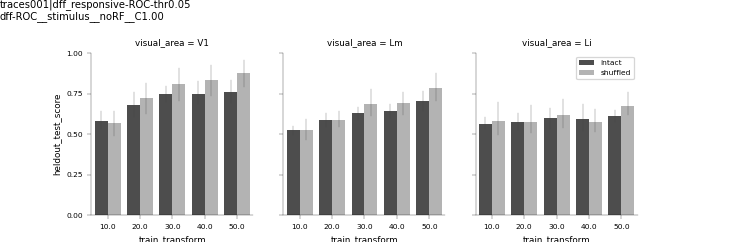

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 split_by_config_acc_intact-v-shuff-corrs


In [68]:
corr_colors={'intact': [0.3]*3, 'shuffled': [0.7]*3}
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,
                  data=df)
fg.map(sns.barplot, 'train_transform', 'heldout_test_score', 'noise_corrs',
      palette=corr_colors, errwidth=0.25) #plot_kws={'errwidth':.25})
pl.legend()
for ax in fg.fig.axes:
    ax.set_box_aspect(1)
    ax.set_ylim([0, 1])
    ax.set_yticks(np.linspace(0, 1, 5))
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8)

pplot.label_figure(fg.fig, '%s\n%s' % (data_id, aggr_id))
figname = 'split_by_config_acc_intact-v-shuff-corrs'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### Relative performance, by train config

In [69]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [89]:
curr_grouper = ['visual_area', 'datakey', 'noise_corrs', 'condition']
curr_grouper.extend(['train_transform'])
df = maindf[~(maindf.novel)]\
            .groupby(curr_grouper).mean()\
            .reset_index()
df.columns

Index(['visual_area', 'datakey', 'noise_corrs', 'condition', 'train_transform',
       'intact', 'novel', 'test_transform', 'fit_time', 'score_time',
       'test_score', 'train_score', 'heldout_test_score', 'C', 'randi',
       'n_trials', 'iteration', 'n_cells'],
      dtype='object')

In [90]:
compare_var='noise_corrs'
metric='heldout_test_score'
c1 = 'shuffled'
c2 = 'intact'
s_=[]
for train_transform, df_ in df.groupby('train_transform'):
    split_ = dec.calculate_relative_scores(df_.copy(), metric=metric,
                                            compare_var=compare_var,
                                            c1=c1, c2=c2)
    split_['train_transform'] = train_transform
    s_.append(split_)
split_scores = pd.concat(s_, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


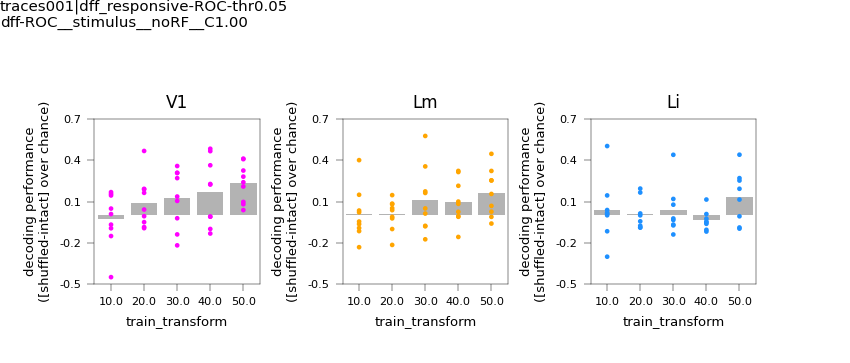

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/size_single/dff-ROC__stimulus__noRF__C1.00 split_by_config_acc-over-chance_intact-v-shuff-corrs


In [91]:
fig, axn=pl.subplots(1, 3, figsize=(7,3), dpi=150, sharex=True, sharey=False)
for va, vg in split_scores.groupby('visual_area'):
    ax = axn[visual_areas.index(va)]
    sns.barplot(x='train_transform', y='shuffled_v_intact', data=vg, ax=ax,
            color=[0.7]*3, ci=None)
    sns.stripplot(x='train_transform', y='shuffled_v_intact', data=vg, ax=ax,
            hue='visual_area', palette=area_colors, jitter=False,
            size=5, marker='.')
    ax.set_title(va)
    ax.legend_.remove()
ymin=-0.5
ymax=0.7
for ax in axn.flat:
    ax.set_box_aspect(1)
    ax.set_ylim([ymin, ymax])
    ax.set_yticks(np.linspace(ymin, ymax, 5))
    ax.set_yticklabels([round(i, 1) for i in np.linspace(ymin, ymax, 5)])
    ax.set_ylabel('decoding performance\n([%s-%s] over chance)' % (c1, c2))
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.5)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname = 'split_by_config_acc-over-chance_intact-v-shuff-corrs'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(dst_dir, figname)

# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [10]:
# dk = '20190616_JC097_fov1'
# va = 'V1'
print(experiment)
sdf = aggr.get_master_sdf(experiment)

blobs


In [11]:
class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

morphlevel 0 106


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


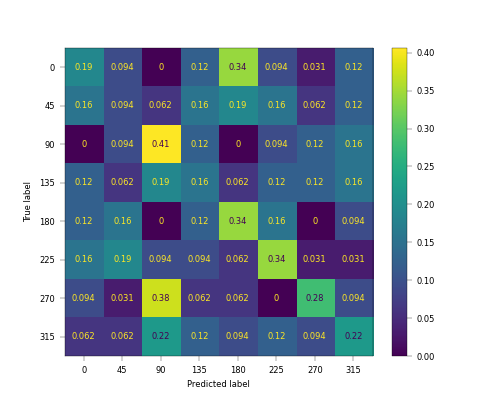

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")